<a href="https://colab.research.google.com/github/grantrzchan/HTX_Armed_Robberies/blob/master/HTX_Armed_Robberies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Data for monthly robberies in Houston, Texas, between 2009 and 2020 year-to-date, compiled using Houston Police Department data'''
import pandas as pd
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from matplotlib import pyplot as plt

#Register datetime converter for matplotlib to prevent issues with seaborn
pd.plotting.register_matplotlib_converters()

#load data set
data_series = pd.read_csv('./data/HTX_robberies.csv', header=None, index_col=0, parse_dates=True, squeeze=True)

In [2]:
#split data set into model development data set and cross validation set, use year 2019 and 2020 of data as cv
data_end = len(data_series) - 16
data_set, cv_set = data_series[0:data_end], data_series[data_end::]
print(f'Data set: {len(data_set)} months, Validation set: {len(cv_set)} months')

#save training and cv sets to csv format
data_set.to_csv('data_set.csv', header = False)
cv_set.to_csv('cv_set.csv', header = False)

Data set: 115 months, Validation set: 16 months


In [3]:
data_set.describe()

count     115.000000
mean      805.365217
std       115.423426
min       464.000000
25%       724.500000
50%       813.000000
75%       877.000000
max      1087.000000
Name: 1, dtype: float64

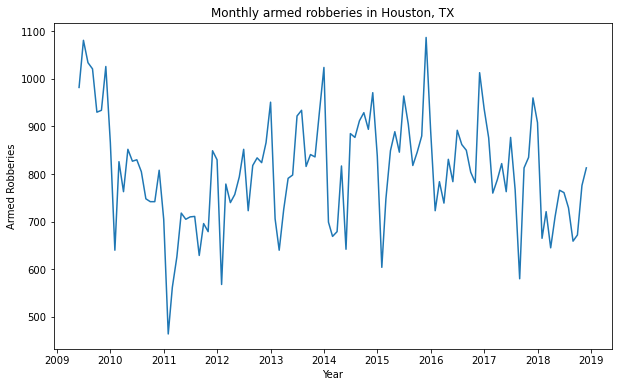

In [4]:
#plot the data
plt.figure(figsize=(10,6))
sns.lineplot(data=data_set)
plt.title('Monthly armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Armed Robberies')
plt.show()

### Line plot observations
- The trend for robberies seem to be relatively sinusoidal
- There is high variability among data points, which corresponds to the wide spread between the quartile ranges observed above
- The variance between data points seem to be much higher during the initial years between 2009 and 2012, but appears stabilized past 2012.
- The data set is non-stationary, since the data points appears to have changing mean and variance over time for each year. We can plot the mean and variance of the data by year to confirm this. We need a boxplot to better visualize the changes in interquartile range, variance and range.

,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,866.0,705.0,830.0,951.0,1024.0,838.0,891.0,937.0,908.0
1,640.0,464.0,568.0,706.0,699.0,604.0,723.0,876.0,665.0
2,826.0,562.0,779.0,640.0,669.0,748.0,784.0,760.0,721.0
3,763.0,626.0,740.0,726.0,679.0,849.0,739.0,788.0,645.0
4,852.0,718.0,757.0,791.0,817.0,889.0,831.0,822.0,710.0
5,827.0,705.0,794.0,798.0,642.0,846.0,784.0,763.0,766.0
6,830.0,710.0,852.0,922.0,885.0,964.0,892.0,877.0,761.0
7,805.0,711.0,723.0,934.0,877.0,905.0,862.0,767.0,729.0
8,748.0,629.0,818.0,816.0,912.0,818.0,850.0,580.0,659.0
9,742.0,696.0,834.0,841.0,929.0,846.0,804.0,813.0,672.0


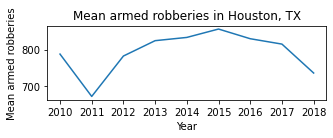

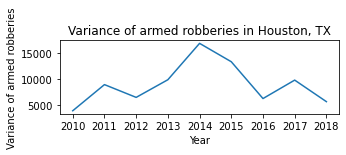

In [5]:
#group data by year for mean, variance and box plot analysis
#2009 only has 6 months of data. We exclude them in the boxplot
y_grps = data_set['2010':'2018'].groupby(pd.Grouper(freq='A'))
yrs = pd.DataFrame({name.year: grp.values for name, grp in y_grps})
plt.figure(figsize=(5,3))
plt.figure(1)
plt.subplot(211)
sns.lineplot(data=yrs.mean())
plt.title('Mean armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Mean armed robberies')
plt.figure(figsize=(5,3))
plt.figure(2)
plt.subplot(212)
sns.lineplot(data=yrs.var())
plt.title('Variance of armed robberies in Houston, TX')
plt.xlabel('Year')
plt.ylabel('Variance of armed robberies')
yrs

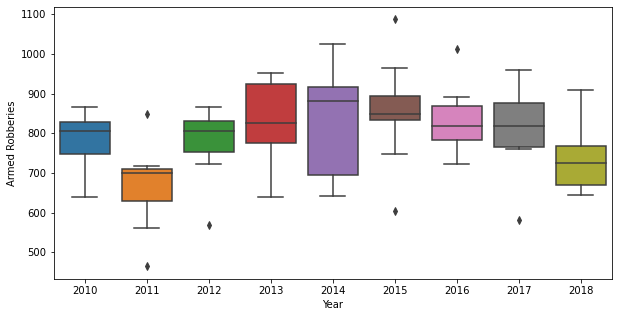

In [6]:
plt.figure(figsize=(10,5))
sns.boxplot(data=yrs)
plt.xlabel('Year')
plt.ylabel('Armed Robberies')
plt.show()

Text(0, 0.5, 'Variance of armed robberies')

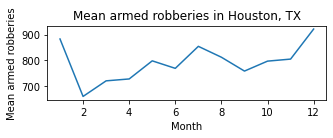

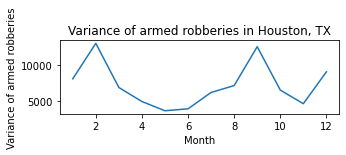

In [7]:
#analysis data by month
mths = yrs.copy().transpose()
mths.columns = range(1,13)
plt.figure(figsize=(5,3))
plt.figure(1)
plt.subplot(211)
sns.lineplot(data=mths.mean())
plt.title('Mean armed robberies in Houston, TX')
plt.xlabel('Month')
plt.ylabel('Mean armed robberies')
plt.figure(figsize=(5,3))
plt.figure(2)
plt.subplot(212)
sns.lineplot(data=mths.var())
plt.title('Variance of armed robberies in Houston, TX')
plt.xlabel('Month')
plt.ylabel('Variance of armed robberies')

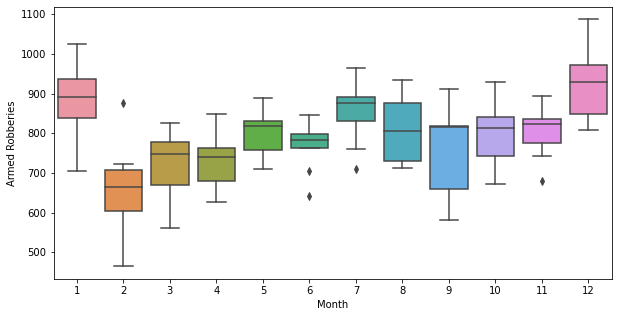

In [8]:
plt.figure(figsize=(10,5))
sns.boxplot(data=mths)
plt.xlabel('Month')
plt.ylabel('Armed Robberies')
plt.show()

### Observations
- Both the mean and variance are changing significantly over time across years, which clearly indicates that the time series is not stationary.
- Across all years, armed robberies peak during the winter months of December and January, decrease in the spring, recovering in the summer, and decrease yet again the fall. This indicates that seasonality is very likely present in the time series. It appears that spikes in armed robberies coincides with the holiday season.

- First let's try to normalize the data, and make the time series stationary, so that it can be used for forecasting.

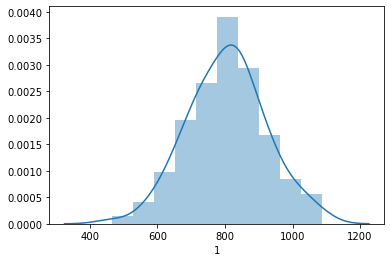

In [9]:
#plot histogram
sns.distplot(data_set,kde=True)
plt.show()

- It appears that the distribution of monthly robberies across all years is already Gaussian.

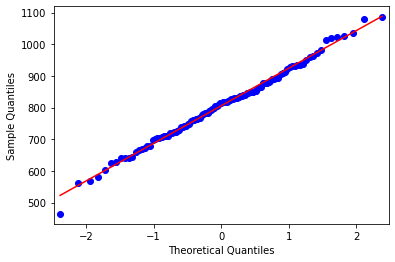

In [10]:
from statsmodels.graphics.gofplots import qqplot
#plot q-q plot
qqplot(data_set, line='r', ax=plt.gca())
plt.show()

- The interquartile plot above further demonstrates that the distribution is Gaussian. We shouldn't need to use transforms to process the data to Gaussian distribution.


## Naive forecast with persistence model

In [11]:
#create training set and test set
X = data_set.values
X = X.astype('float32')

#start with train set of 50%
train_size = int(0.5*len(X))
train_set, test_set = X[0:train_size], X[train_size::]

In [12]:
#use walk forward validation to create baseline prediction forecast using the persistence model
#create forecast history
historic_obs = [x for x in train_set]
#create baseline predictions
predictions = []
for i in range(len(test_set)):
    #make prediction at t using observation at t-1
    y_hat = historic_obs[-1]
    predictions.append(y_hat)
    #actual t observation from test set
    observation = test_set[i]
    #update historic observations with actual t observation
    historic_obs.append(observation)
    print(f'Predicted: {y_hat: .3f}, Expected: {observation: .3f}')
#report the performance of the forecast using RMSE
rmse = sqrt(mse(test_set, predictions))
print(f'RMSE: {rmse: .3f}')

Predicted:  699.000, Expected:  669.000
Predicted:  669.000, Expected:  679.000
Predicted:  679.000, Expected:  817.000
Predicted:  817.000, Expected:  642.000
Predicted:  642.000, Expected:  885.000
Predicted:  885.000, Expected:  877.000
Predicted:  877.000, Expected:  912.000
Predicted:  912.000, Expected:  929.000
Predicted:  929.000, Expected:  894.000
Predicted:  894.000, Expected:  971.000
Predicted:  971.000, Expected:  838.000
Predicted:  838.000, Expected:  604.000
Predicted:  604.000, Expected:  748.000
Predicted:  748.000, Expected:  849.000
Predicted:  849.000, Expected:  889.000
Predicted:  889.000, Expected:  846.000
Predicted:  846.000, Expected:  964.000
Predicted:  964.000, Expected:  905.000
Predicted:  905.000, Expected:  818.000
Predicted:  818.000, Expected:  846.000
Predicted:  846.000, Expected:  880.000
Predicted:  880.000, Expected:  1087.000
Predicted:  1087.000, Expected:  891.000
Predicted:  891.000, Expected:  723.000
Predicted:  723.000, Expected:  784.00

In [13]:
def normalizer(data):
    ts_avg, ts_std = data.mean(), data.std()
    normalized = (data - ts_avg)/ts_std
    return normalized, ts_avg, ts_std

def inv_normalizer(normalized, ts_avg, ts_std):
    data = (normalized*ts_std) + ts_avg
    return data

normalized_data_set, n_ts_avg, n_ts_std = normalizer(data_set)

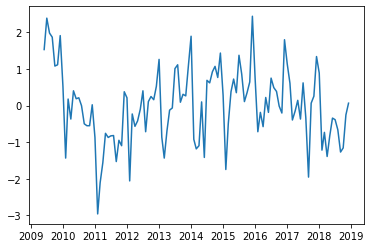

In [14]:
plt.plot(normalized_data_set)
plt.show()

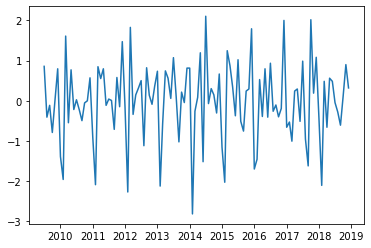

In [15]:
# #Employ first order differencing
normalized_data_set = normalized_data_set.diff().dropna()
plt.plot(normalized_data_set)
plt.show()

In [16]:
#function to eliminate heteroskedasticity and seasonality
def rm_vol_and_sea(data):
    annual_volatility = data.groupby(data.index.year).std()
    month_avgs = data.groupby(data.index.month).mean()
    data_annual_vol = data.index.map(lambda d: annual_volatility.loc[d.year])
    data_month_avg = data.index.map(lambda d: month_avgs.loc[d.month])
    treated = (data/data_annual_vol) - data_month_avg
    return treated, data_annual_vol, data_month_avg

In [17]:
#function to add original heteroskedasticity and seasonality
def add_vol_and_sea(treated, data_annual_vol, data_month_avg):
    data = (treated + data_month_avg) * data_annual_vol
    return data

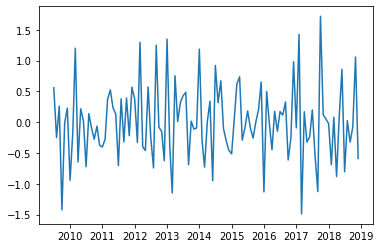

In [18]:
normalized_data_set, data_annual_vol, data_month_avg = rm_vol_and_sea(normalized_data_set)
plt.plot(normalized_data_set)
plt.show()

In [19]:
#check for stationarity of the data set using the augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def check_stationary(data):
    '''function to check data stationarity using adfuller from statsmodel'''
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]: .3f}')
    print(f'p-value: {result[1]: .3f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


In [20]:
check_stationary(normalized_data_set.values)

ADF Statistic: -6.959
p-value:  0.000
Critical Values:
	1%: -3.492
	5%: -2.888
	10%: -2.581


### Dickey-Fuller Test observation:
- The test statistic value is -6.959, which is smaller than the critical value of 1% at -3.492. This indicates that we can reject the null hypothesis, which claims that the data is non-stationary, with a significance level of less than 1%.
- Differencing by order of 1 seems to have made the data set stationary.

In [21]:
#create training set and test set
X = normalized_data_set.values
X = X.astype('float32')

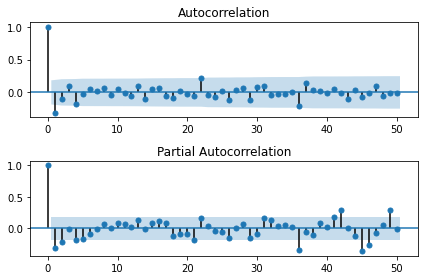

In [22]:
#create ACF and PACF plots to check for autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure()
plt.subplot(211)
plot_acf(X, lags=50, ax=plt.gca())
plt.subplot(212)
plot_pacf(X, lags=50, ax=plt.gca())

#fix any plot overlap with tight layout
plt.tight_layout()
plt.show()

### ACF and PACF plot observations

- The ACF plot shows that lags are significant for the first month.
- The PACF plot shows that lags are significant for likely just the first month.
- The plot suggest an ARMA(1,1) may be used for modelling.
- We have already accounted for the differencing order of 1,thus an ARIMA(1,0,1) should be a good starting point for modelling the data.

In [23]:
from statsmodels.tsa.arima_model import ARIMA
#create training set and test set
X = normalized_data_set.values
X = X.astype('float32')
X_size = int(0.5*len(X))
train_data_annual_vol, train_data_month_avg = data_annual_vol[0:X_size], data_month_avg[0:X_size]
test_data_annual_vol, test_data_month_avg = data_annual_vol[X_size:], data_month_avg[X_size:]
train_X, test_X = X[0:X_size], X[X_size:]

#Try an ARIMA(1,0,1) model
arima_hist = [x for x in train_X]
arima_pred = []
resid = []
for i in range(len(test_X)):
    # predict
    model = ARIMA(arima_hist, order=(1,0,1))
    model_fit = model.fit(disp=0)
    arima_y_hat = model_fit.forecast()[0]
    arima_pred.append(arima_y_hat)
    # observation
    obs = test_X[i]
    arima_hist.append(obs)
    arima_y_hat = inv_normalizer(add_vol_and_sea(arima_y_hat, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    # Convert obs to original units
    obs = inv_normalizer(add_vol_and_sea(obs, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    # calculate residuals
    resid.append(abs(obs - arima_y_hat).item(0))
    print('>Predicted=%.3f, Expected=%.3f' % (arima_y_hat, obs))
# report performance
rmse = sqrt(mse(test_X, arima_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=849.533, Expected=815.365
>Predicted=910.723, Expected=943.365
>Predicted=758.082, Expected=630.365
>Predicted=963.397, Expected=1048.365
>Predicted=719.335, Expected=797.365
>Predicted=708.511, Expected=840.365
>Predicted=783.936, Expected=822.365
>Predicted=794.689, Expected=770.365
>Predicted=955.696, Expected=882.365
>Predicted=761.661, Expected=672.365
>Predicted=597.986, Expected=571.365
>Predicted=889.465, Expected=949.365
>Predicted=797.911, Expected=906.365
>Predicted=843.250, Expected=845.365
>Predicted=761.360, Expected=762.365
>Predicted=896.903, Expected=923.365
>Predicted=749.819, Expected=746.365
>Predicted=750.440, Expected=718.365
>Predicted=844.657, Expected=833.365
>Predicted=821.676, Expected=839.365
>Predicted=927.724, Expected=1012.365
>Predicted=716.444, Expected=609.365
>Predicted=609.298, Expected=637.365
>Predicted=866.174, Expected=866.365
>Predicted=813.406, Expected=760.365
>Predicted=896.960, Expected=897.365
>Predicted=781.775, Expected=758.365

In [24]:
def plot_results(test_X, arima_pred):    
    pred_y = [inv_normalizer(add_vol_and_sea(arima_pred[i], test_data_annual_vol[i], test_data_month_avg[i]), 
                                    n_ts_avg, n_ts_std) for i in range(len(test_X))]
    y = inv_normalizer(add_vol_and_sea(test_X, test_data_annual_vol, test_data_month_avg), n_ts_avg, n_ts_std)
    #plot predictions with actuals
    plt.plot(y)
    plt.plot(pred_y, color='g')
    plt.show()


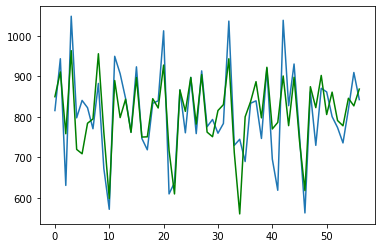

In [25]:
plot_results(test_X, arima_pred)

In [26]:
#Use Grid Search to find the optimal p,d,q hyperparameters
import itertools
def evaluate_arima(data, arima_order):
    '''Function to evaluate data set X based on ARIMA order with some (p,d,q) and return RMSE'''
    #prepare training data
    data = data.astype('float32')
    train_size = int(len(data) * 0.5)
    train, test = data[0:train_size], data[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mse(test, predictions))
    return rmse

def evaluate_arima_models(data, p_val, d_val, q_val):
    #convert data set to float to prevent numpy error
    data = data.astype('float32')
    best_rmse, best_config = float('inf'), None
    #loop through all values of p,d,q to try every configuration order for ARIMA
    for p, d, q in itertools.product(p_val, d_val, q_val):
        order = (p,d,q)
        try:
            rmse = evaluate_arima(data, order)
            if rmse < best_rmse:
                best_config, best_rmse = order, rmse
            print('ARIMA%s, RMSE = %.3f' % (order, rmse))
        except:
            continue
    print('Best ARIMA%s, RMSE = %.3f' % (best_config, best_rmse))
    return best_config

In [27]:
#evaluate data set with all possible hyperparameter configurations
p_val = range(0,3)
d_val = range(0,3)
q_val = range(0,3)

#turn off verbose warning messages
import warnings
warnings.filterwarnings("ignore")
best_config = evaluate_arima_models(X, p_val, d_val, q_val)

ARIMA(0, 0, 0), RMSE = 0.613
ARIMA(0, 0, 1), RMSE = 0.572
ARIMA(0, 0, 2), RMSE = 0.565
ARIMA(0, 1, 0), RMSE = 1.002
ARIMA(0, 1, 1), RMSE = 0.625
ARIMA(0, 1, 2), RMSE = 0.605
ARIMA(0, 2, 0), RMSE = 1.782
ARIMA(0, 2, 1), RMSE = 1.012
ARIMA(0, 2, 2), RMSE = 0.634
ARIMA(1, 0, 0), RMSE = 0.584
ARIMA(1, 0, 1), RMSE = 0.563
ARIMA(1, 1, 0), RMSE = 0.794
ARIMA(1, 2, 0), RMSE = 1.260
ARIMA(2, 0, 0), RMSE = 0.589
ARIMA(2, 0, 1), RMSE = 0.582
ARIMA(2, 1, 0), RMSE = 0.740
ARIMA(2, 1, 1), RMSE = 0.616
ARIMA(2, 2, 0), RMSE = 1.026
Best ARIMA(1, 0, 1), RMSE = 0.563


- Using a grid search approach, we confirmed out that ARIMA(1,0,1) is indeed the best model to use for our forecast.

In [28]:
# #try a rolling window ARIMA(1,0,1) model
arima_hist = [x for x in train_X]
arima_pred = []
resid = []
for i in range(len(test_X)):
    # predict
    model = ARIMA(arima_hist[i:], order=best_config)
    model_fit = model.fit(disp=0)
    arima_y_hat = model_fit.forecast()[0]
    arima_pred.append(arima_y_hat)
    # observation
    obs = test_X[i]
    arima_hist.append(obs)
    # calculate residuals
    resid.append(abs(obs - arima_y_hat).item(0))
    # Convert y_hat back to original units
    arima_y_hat = inv_normalizer(add_vol_and_sea(arima_y_hat, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    # Convert obs to original units
    obs = inv_normalizer(add_vol_and_sea(obs, test_data_annual_vol[i], test_data_month_avg[i]), n_ts_avg, n_ts_std)
    print('>Predicted=%.3f, Expected=%.3f' % (arima_y_hat, obs))
# report performance
rmse = sqrt(mse(test_X, arima_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=849.533, Expected=815.365
>Predicted=908.859, Expected=943.365
>Predicted=758.833, Expected=630.365
>Predicted=969.290, Expected=1048.365
>Predicted=726.956, Expected=797.365
>Predicted=710.858, Expected=840.365
>Predicted=778.532, Expected=822.365
>Predicted=791.396, Expected=770.365
>Predicted=956.823, Expected=882.365
>Predicted=747.560, Expected=672.365
>Predicted=605.835, Expected=571.365
>Predicted=909.766, Expected=949.365
>Predicted=828.627, Expected=906.365
>Predicted=862.580, Expected=845.365
>Predicted=779.224, Expected=762.365
>Predicted=918.371, Expected=923.365
>Predicted=770.283, Expected=746.365
>Predicted=775.703, Expected=718.365
>Predicted=881.275, Expected=833.365
>Predicted=856.406, Expected=839.365
>Predicted=965.456, Expected=1012.365
>Predicted=730.683, Expected=609.365
>Predicted=653.320, Expected=637.365
>Predicted=901.885, Expected=866.365
>Predicted=849.571, Expected=760.365
>Predicted=944.529, Expected=897.365
>Predicted=828.278, Expected=758.365

- A rolling window approach actually results in worse accuracy.

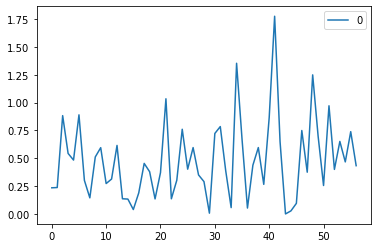

In [29]:
arima101_resid = pd.DataFrame(resid)
arima101_resid.plot()
plt.show()

- The residuals do not seem to be white noise, because from visual inspection, we can see that the mean and variance of the data set is still changing. From our initial treatment of the problem, we assumed that the model describing the data is additive, such that we can eliminate heteroskadasticity and seaonality by using division. Let's check our intuition with seasonal decompose from statsmodels.

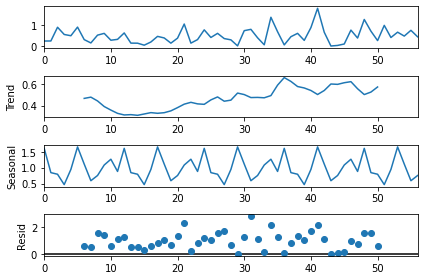

count    45.000000
mean      0.992492
std       0.649578
min       0.000569
25%       0.561229
50%       1.009276
75%       1.300574
max       2.804031
Name: resid, dtype: float64

In [30]:
#Assuming that the time series can be described with a multiplicative model,
#let's check for the seasonality of the model over a period of 12 months
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(arima101_resid, model='multiplicative', freq=12)
decomposed.plot()
plt.show()
decomposed.resid.describe()

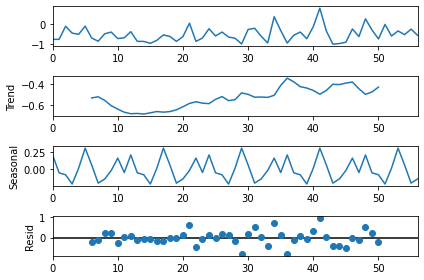

count    45.000000
mean     -0.009431
std       0.351143
min      -0.815647
25%      -0.176445
50%      -0.015517
75%       0.142117
max       0.966917
Name: resid, dtype: float64

In [31]:
#Assuming that the time series can be described with a additive model
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(arima101_resid-1, model='additive', freq=12)
decomposed.plot()
plt.show()
decomposed.resid.describe()

- From the above decompositions, it appears that the multiplicative model more accurately describes the armed robbery time series data, because the residuals of the additive model has a smaller and more consistent variance and cluster at a bias value of approximately 1. Thus we can we assume that the model is approximately given as:

\begin{align}
\ y(t) & = \ f(T) * f(S) * (W+1) \\
\end{align}

- Where y(t) is the model, f(T) is the trend component, f(S) is the seasonality component and W+1 is the white noise component with bias of 1.

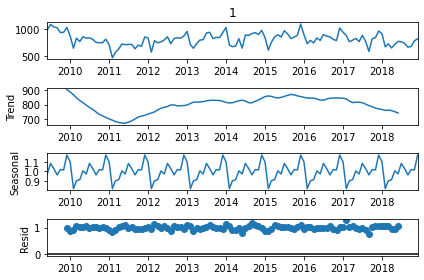

count    103.000000
mean       0.998622
std        0.076336
min        0.758357
25%        0.958185
50%        1.000600
75%        1.045298
max        1.268907
Name: resid, dtype: float64

In [32]:
decomposed = seasonal_decompose(data_set, model='mult', freq=12)
decomposed.plot()
plt.show()
decomposed.resid.describe()

- Seasonal decomposition using the original data set also yields the same conclusion. Since seasonality is an important component of the series, we should use a SARIMA model to forecast the data. We can use pyramid auto arima to calculate the best possible SARIMA model to use

In [33]:
from pmdarima import auto_arima
#create training set and test set
normalized, ts_avg, ts_std  = normalizer(data_set)
X = normalized.values
X = X.astype('float32')

#start with train set of 50%
train_size = int(0.5*len(X))
train_X, test_X = X[0:train_size], X[train_size::]

In [34]:
test_model=auto_arima(train_X,
 start_p=1, start_q=1, 
 d=1, max_d=3,
 start_P=1, D=1, max_D=3, 
 start_Q=1, m=12,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True, seasonal=True,
 max_iters=100)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=93.760, BIC=104.466, Time=0.507 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=107.283, BIC=110.852, Time=0.016 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=93.347, BIC=100.483, Time=0.158 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=90.884, BIC=98.021, Time=0.202 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=105.344, BIC=107.128, Time=0.014 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=97.909, BIC=103.262, Time=0.045 seconds
Fit ARIMA(0,1,1)x(1,1,1,12) [intercept=True]; AIC=91.997, BIC=100.918, Time=0.336 seconds
Fit ARIMA(0,1,1)x(0,1,2,12) [intercept=True]; AIC=92.286, BIC=101.207, Time=0.624 seconds
Fit ARIMA(0,1,1)x(1,1,0,12) [intercept=True]; AIC=90.062, BIC=97.199, Time=0.178 seconds
Fit ARIMA(0,1,1)x(2,1,0,12) [intercept=True]; AIC=92.018, BIC=100.939, Time=0.569 seconds
Fit ARIMA(0,1,1)x(2,1,1,12) [intercept=True]; AIC=93.821

In [35]:
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   57
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -41.031
Date:                             Mon, 24 Aug 2020   AIC                             90.062
Time:                                     23:50:13   BIC                             97.199
Sample:                                          0   HQIC                            92.709
                                              - 57                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0904      0.057      1.579      0.114      -0.022       0.203
ma.L1         -0.5276      0.150     -3.523      0.000      -0.821      -0.234
ar.S.L12      -0.5372      0.174     -3.094      0.002      -0.878      -0.197
sigma2         0.3419      0.088      3.879      0.000       0.169       0.515
===================================================================================
Ljung-Box (Q):                       21.86   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.99   Prob(JB):                         0.68
Heteroskedasticity (H):               3.27   Skew:                            -0.29
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Try an SARIMAX(0,1,1) model
sarimax_hist = [x for x in train_X]
sarimax_pred = []
sarimax_resid = []
for i in range(len(test_X)):
    # predict
    model = SARIMAX(sarimax_hist, order=(0,1,1), seasonal_order=(1,1,0,12))
    model_fit = model.fit(disp=0)
    sarimax_y_hat = model_fit.forecast()[0]
    sarimax_pred.append(sarimax_y_hat)
    # observation
    obs = test_X[i]
    sarimax_hist.append(obs)
    # Convert back to original units
    sarimax_y_hat = inv_normalizer(sarimax_y_hat, ts_avg, ts_std)
    obs = inv_normalizer(obs, ts_avg, ts_std)
    # calculate residuals
    sarimax_resid.append(abs(obs - sarimax_y_hat).item(0))
    print('>Predicted=%.3f, Expected=%.3f' % (sarimax_y_hat, obs))
# report performance
rmse = sqrt(mse(test_X, sarimax_pred))
print(f'RMSE: {rmse: .3f}')

>Predicted=793.017, Expected=669.000
>Predicted=748.569, Expected=679.000
>Predicted=752.459, Expected=817.000
>Predicted=808.570, Expected=642.000
>Predicted=817.189, Expected=885.000
>Predicted=819.859, Expected=877.000
>Predicted=798.866, Expected=912.000
>Predicted=884.529, Expected=929.000
>Predicted=903.529, Expected=894.000
>Predicted=973.133, Expected=971.000
>Predicted=1062.612, Expected=838.000
>Predicted=645.739, Expected=604.000
>Predicted=576.409, Expected=748.000
>Predicted=703.287, Expected=849.000
>Predicted=895.712, Expected=889.000
>Predicted=786.930, Expected=846.000
>Predicted=1016.359, Expected=964.000
>Predicted=987.537, Expected=905.000
>Predicted=913.217, Expected=818.000
>Predicted=874.580, Expected=846.000
>Predicted=835.630, Expected=880.000
>Predicted=946.808, Expected=1087.000
>Predicted=1002.569, Expected=891.000
>Predicted=661.737, Expected=723.000
>Predicted=766.410, Expected=784.000
>Predicted=839.977, Expected=739.000
>Predicted=867.642, Expected=831.0

In [37]:
def plot_results_sarimax(test_set, sarimax_pred):    
    pred_y = [inv_normalizer(sarimax_pred[i], ts_avg, ts_std) for i in range(len(test_set))]
    y = inv_normalizer(test_set, ts_avg, ts_std)
    #plot predictions with actuals
    plt.plot(y)
    plt.plot(pred_y, color='g')
    plt.show()
# sns.lineplot(data=inv_normalizer(test_set, ts_avg, ts_std))
# sns.lineplot(data=inv_normalizer(sarimax_pred, ts_avg, ts_std))
# print(sarimax_pred)

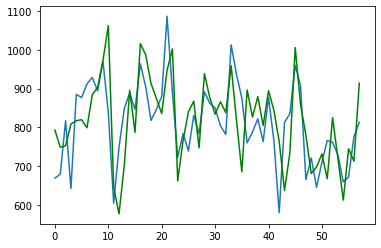

In [38]:
plot_results_sarimax(test_X, sarimax_pred)

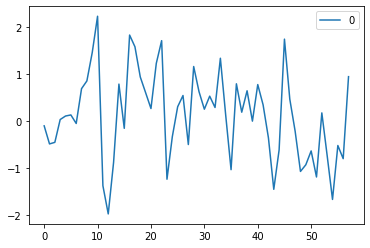

In [39]:
sarimax_resid = pd.DataFrame(sarimax_pred)
sarimax_resid.plot()
plt.show()

- Let's model the residuals with an additive seasonal decomposition model to see if there are any remaining trends or patterns that the SARIMAX(0,1,1) has failed to capture

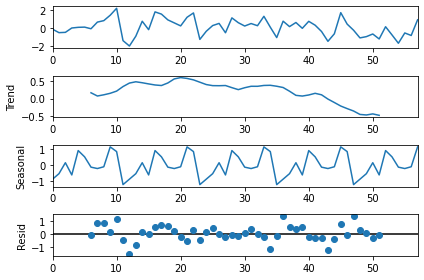

In [42]:
seasonal_decompose(sarimax_resid, model='add', freq=12).plot()
plt.show()